# Potential flow around a rotating cylinder

Philipp Schlatter, LSTM/FAU 2025

Colab: https://colab.research.google.com/github/pschlatt1/notebooks/blob/main/cylinder.ipynb


<a target="_blank" href="https://colab.research.google.com/github/pschlatt1/notebooks/blob/main/cylinder.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

### Preliminaries

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  # for Google Colab and interative figures
  !pip install -q ipympl
  get_ipython().kernel.do_shutdown(restart=True)

In [2]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  # for Google Colab and interative figures
  # !pip install -q ipympl
  #get_ipython().kernel.do_shutdown(restart=True)
  from google.colab import output
  output.enable_custom_widget_manager()

In [3]:
%matplotlib widget
import numpy as np
from scipy import integrate
from matplotlib import pyplot as plt

### Parameters

Cylinder parameter: (cylinder centre $x_\mathrm{center}$, $y_\mathrm{center}$, freestream velocity $U_\infty$, radius $R$, circulation $\Gamma$). Positive circulation corresponds to counter-clockwise rotation, negataive circulation to clockwise rotation of the cylinder.

In [4]:
x_center, y_center = 0.0, 0.0
u_inf = 1            
R = 4
Gamma =  -40
#Gamma = -4 *np.pi * R*u_inf

Define the strength $M$ of the dipole such that we get a cylinder with radius $R$:

$$ M = 2 \pi R^2 U_\infty$$

The two stagnation points will be on the cylinder surface if

$$ |\Gamma| \le 4 \pi R U_\infty $$

In [5]:
M = (R**2)*2*np.pi*u_inf  # doublet for circle with radius R

### Definition of the mesh

You can use either Cartesian or polar coordinates:

In [6]:
class Cartesian:
    def __init__(self,N,x_start,x_end,y_start,y_end):
        self.X, self.Y = np.meshgrid(np.linspace(x_start, x_end, N), np.linspace(y_start, y_end, N))
        self.type = "Cartesian"
        
class Polar:
    def __init__(self,N,r_start,r_end):
        xx,yy = np.meshgrid(np.linspace(r_start,r_end,N),np.linspace(0,2*np.pi,N,endpoint=True))
        self.X, self.Y = xx*np.cos(yy)+x_center,xx*np.sin(yy)+y_center
        self.phi = yy
        self.type = "Polar"
        
class Velocity:
    def __init__(self,mesh):
        self.u = mesh.X*0
        self.v = mesh.X*0
        self.p = mesh.X*0
        
    def comp_p(self,u_ref):
        self.p = 2*(0.5*u_ref**2-0.5*(self.u**2 + self.v**2))

One can either choose a Cartesian mesh or a polar mesh. Some functionality is only working for either of the meshes.

In [7]:
mesh = Cartesian(100,-15,15,-15,15)    # for streamplot
mesh = Polar(100,R,5*R)            # for cp(phi) curve

### Elementary flow solutions

Definition of the basic potential flow solutions. Eventually one could add the velocity potential $\phi$ as well.

In [8]:
class Doublet:
    # strength M
    def __init__(self, strength, x, y):
        self.strength = strength
        self.x, self.y = x, y

    def vel(self, mesh):
        u = (-self.strength / (2 * np.pi) *
             ((mesh.X - self.x)**2 - (mesh.Y - self.y)**2) /
             ((mesh.X - self.x)**2 + (mesh.Y - self.y)**2)**2)
        v = (-self.strength / (2 * np.pi) *
             2 * (mesh.X - self.x) * (mesh.Y - self.y) /
             ((mesh.X - self.x)**2 + (mesh.Y - self.y)**2)**2)
        return u, v

    def psi(self, mesh):
        psi = -(self.strength / (2 * np.pi) *
               (mesh.Y - self.y) / ((mesh.X - self.x)**2 + (mesh.Y - self.y)**2))
        return psi

In [9]:
class Vortex:
    def __init__(self, strength, x, y):
        self.strength = strength  # Gamma
        self.x, self.y = x, y

    def vel(self, mesh):
        u = -self.strength / (2 * np.pi) * (mesh.Y - self.y) / ((mesh.X - self.x)**2 + (mesh.Y - self.y)**2)
        v = +self.strength / (2 * np.pi) * (mesh.X - self.x) / ((mesh.X - self.x)**2 + (mesh.Y - self.y)**2)
        return u, v

    def psi(self, mesh):
        psi =  -self.strength / ( 4*np.pi) * np.log((mesh.X - self.x)**2 + (mesh.Y - self.y)**2)
        return psi

In [10]:
class Freestream:
    def __init__(self, strength, alpha):
        self.strength = strength
        self.alpha = alpha
        
    def vel(self, mesh):
        u = mesh.X*0 + self.strength*np.cos(self.alpha) 
        v = mesh.X*0 + self.strength*np.sin(self.alpha) 
        return u, v
            
    def psi(self, mesh):
        psi = self.strength*(-mesh.X*np.sin(self.alpha) + mesh.Y*np.cos(self.alpha))
        return psi

Compute the solution solution:

In [11]:
# Flow around a cylinder
fst = Freestream(u_inf,0)
u1,v1 = fst.vel(mesh)
psi1 = fst.psi(mesh)

doublet = Doublet(strength=M, x=x_center,y=y_center)
u2, v2 = doublet.vel(mesh)
psi2 = doublet.psi(mesh)

vortex = Vortex(strength=Gamma, x=x_center,y=y_center)
u3, v3 = vortex.vel(mesh)
psi3 = vortex.psi(mesh)

U = Velocity(mesh)
U.u = u1+u2+u3
U.v = v1+v2+v3
psi = psi1+psi2+psi3

# R = np.sqrt(M/(2*np.pi*u_inf))

theta = np.linspace(0.0, 2 * np.pi, 100)
x_cylinder, y_cylinder = (x_center + R * np.cos(theta),
                          y_center + R * np.sin(theta))

### Plot the velocity and pressure solutions:

In [12]:
# streamplot. Works only for Cartesian grids
if mesh.type=="Cartesian":
    plt.figure(figsize=(6,6))
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')
    plt.axis('equal')
    plt.streamplot(mesh.X, mesh.Y, U.u, U.v, density=1.5, linewidth=0.5, arrowsize=1, arrowstyle='->')
    plt.plot(x_cylinder, y_cylinder, color='k', linestyle='-', linewidth=2)

    if (np.abs(Gamma)>4*np.pi*R*u_inf):
        x_stagn1, y_stagn1 = 0,1/(4*np.pi*u_inf)*(Gamma-np.sqrt(Gamma**2-(4*np.pi*R*u_inf)**2))
        x_stagn2, y_stagn2 = 0,1/(4*np.pi*u_inf)*(Gamma+np.sqrt(Gamma**2-(4*np.pi*R*u_inf)**2))
    else:
        x_stagn1, y_stagn1 = ((+np.sqrt(R**2 - (Gamma / (4 * np.pi * u_inf))**2)+x_center),
                      +(Gamma / (4 * np.pi * u_inf))+y_center)
        x_stagn2, y_stagn2 = ((-np.sqrt(R**2 - (Gamma / (4 * np.pi * u_inf))**2)+x_center),
                      +(Gamma / (4 * np.pi * u_inf))+y_center)
    plt.scatter([x_stagn1, x_stagn2], [y_stagn1, y_stagn2],
               color='g', s=80, marker='o');
    plt.show()
else:
    print("Only works for Cartesian meshes")
        

Only works for Cartesian meshes


In [13]:
# streamplot and streamlines. Works only for Cartesian grids
if mesh.type=="Cartesian":
    plt.figure(figsize=(6,6))
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')
    plt.axis('equal')
    plt.contour(mesh.X, mesh.Y, psi, levels=np.arange(-40,40,1),linewidths=1,linestyles='-',colors='r')

    plt.streamplot(mesh.X, mesh.Y, U.u, U.v, density=1, linewidth=0.5, arrowsize=1, arrowstyle='->')

    plt.plot(x_cylinder, y_cylinder, color='k', linestyle='-', linewidth=2)

    if (np.abs(Gamma)>4*np.pi*R*u_inf):
        x_stagn1, y_stagn1 = 0,1/(4*np.pi*u_inf)*(Gamma-np.sqrt(Gamma**2-(4*np.pi*R*u_inf)**2))
        x_stagn2, y_stagn2 = 0,1/(4*np.pi*u_inf)*(Gamma+np.sqrt(Gamma**2-(4*np.pi*R*u_inf)**2))
    else:
        x_stagn1, y_stagn1 = ((+np.sqrt(R**2 - (Gamma / (4 * np.pi * u_inf))**2)+x_center),
                   +(Gamma / (4 * np.pi * u_inf))+y_center)
        x_stagn2, y_stagn2 = ((-np.sqrt(R**2 - (Gamma / (4 * np.pi * u_inf))**2)+x_center),
                      +(Gamma / (4 * np.pi * u_inf))+y_center)
    plt.scatter([x_stagn1, x_stagn2], [y_stagn1, y_stagn2],
               color='g', s=80, marker='o');

    #plt.colorbar()
    plt.show()
else:
    print("Only works for Cartesian meshes")
        

Only works for Cartesian meshes


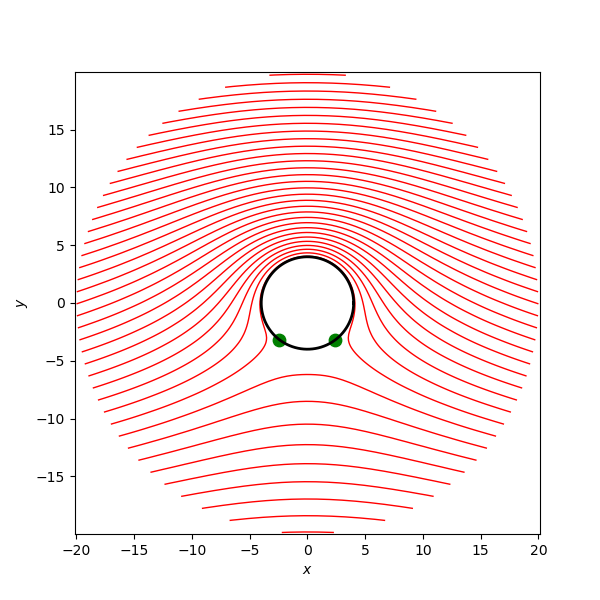

In [14]:
# streamfunction and stagnation points
plt.figure(figsize=(6,6))
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.axis('equal')
plt.contour(mesh.X, mesh.Y, psi, levels=np.arange(-40,40,1),linewidths=1,linestyles='-',colors='r')
plt.plot(x_cylinder, y_cylinder, color='k', linestyle='-', linewidth=2)
if (np.abs(Gamma)>4*np.pi*R*u_inf):
    x_stagn1, y_stagn1 = 0,1/(4*np.pi*u_inf)*(Gamma-np.sqrt(Gamma**2-(4*np.pi*R*u_inf)**2))
    x_stagn2, y_stagn2 = 0,1/(4*np.pi*u_inf)*(Gamma+np.sqrt(Gamma**2-(4*np.pi*R*u_inf)**2))
else:
    x_stagn1, y_stagn1 = ((+np.sqrt(R**2 - (Gamma / (4 * np.pi * u_inf))**2)+x_center),
                      +(Gamma / (4 * np.pi * u_inf))+y_center)
    x_stagn2, y_stagn2 = ((-np.sqrt(R**2 - (Gamma / (4 * np.pi * u_inf))**2)+x_center),
                      +(Gamma / (4 * np.pi * u_inf))+y_center)
plt.scatter([x_stagn1, x_stagn2], [y_stagn1, y_stagn2],
               color='g', s=80, marker='o');
plt.show()

C:\Users\pschl\AppData\Local\Temp\ipykernel_11892\3647221430.py:6: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plt.pcolor(mesh.X, mesh.Y, U.p/u_inf**2,vmax=1,vmin=-10,cmap='jet')


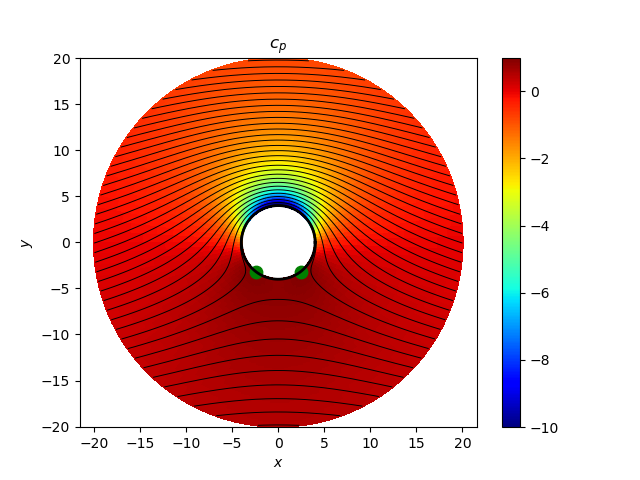

In [15]:
# streamfunction and pressure coefficient cp. Better in polar coordinates
U.comp_p(u_inf)
plt.figure()
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.pcolor(mesh.X, mesh.Y, U.p/u_inf**2,vmax=1,vmin=-10,cmap='jet')
plt.axis('equal')
plt.colorbar()
plt.plot(x_cylinder, y_cylinder, color='k', linestyle='-', linewidth=2)
plt.contour(mesh.X, mesh.Y, psi, levels=np.arange(-40,40,1),linewidths=0.7,linestyles='-',colors='k')
plt.title('$c_p$')
if (np.abs(Gamma)>4*np.pi*R*u_inf):
    x_stagn1, y_stagn1 = 0,1/(4*np.pi*u_inf)*(Gamma-np.sqrt(Gamma**2-(4*np.pi*R*u_inf)**2))
    x_stagn2, y_stagn2 = 0,1/(4*np.pi*u_inf)*(Gamma+np.sqrt(Gamma**2-(4*np.pi*R*u_inf)**2))
else:
    x_stagn1, y_stagn1 = ((+np.sqrt(R**2 - (Gamma / (4 * np.pi * u_inf))**2)+x_center),
                      +(Gamma / (4 * np.pi * u_inf))+y_center)
    x_stagn2, y_stagn2 = ((-np.sqrt(R**2 - (Gamma / (4 * np.pi * u_inf))**2)+x_center),
                      +(Gamma / (4 * np.pi * u_inf))+y_center)
plt.scatter([x_stagn1, x_stagn2], [y_stagn1, y_stagn2],
               color='g', s=80, marker='o');

plt.show()

Compute $ c_p= \frac{p-p_\infty}{\frac12  \rho U_\infty^2}=1-(u/U_\infty)^2$. The exact solution is $c_p = 1-4\sin^2 \theta-\left( \frac{\Gamma}{2\pi U_\infty R}\right)^2 + \frac{2\Gamma \sin\theta}{\pi U_\infty R}$

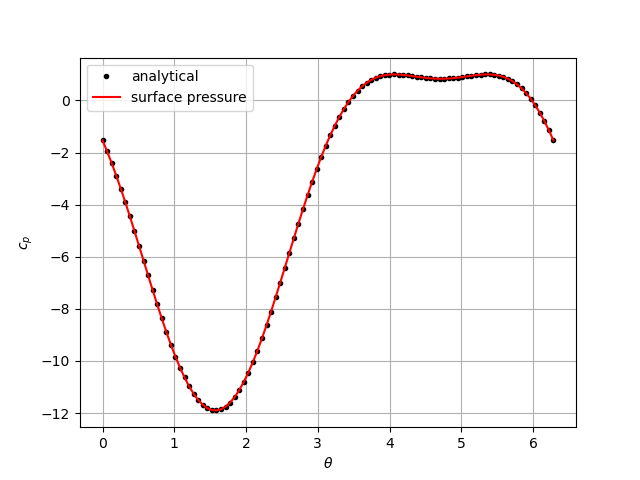

In [16]:
# compute $c_p$ as function of $\phi$, works only if you use the polar mesh
if mesh.type=="Polar":
    plt.figure()
    cp = U.p[:,0]/u_inf**2 ; phi = mesh.phi[:,0]
    cp_ex = 1-4*np.sin(phi)**2-(Gamma/(2*np.pi*u_inf*R))**2+2*Gamma*np.sin(phi)/(np.pi*u_inf*R)
    plt.plot(phi,cp_ex,'k.',label='analytical')    
    plt.plot(phi,cp,'r',label='surface pressure')
    plt.xlabel(r'$\theta$')
    plt.ylabel(r'$c_p$')
    plt.legend()
    plt.grid()
    plt.show()
else:
    print("Only works for Polar meshes")

In [17]:
if mesh.type=="Polar":
    # Lift coefficient C_L using Kutta theorem (minus sign as the circulation is measured in the negative direction for KJ)
    C_L_kutta=-Gamma/u_inf/R
    # Lift and drag using integration
    dphi = R*(phi[1]-phi[0])
    C_L=-dphi*np.sum(cp[0:-1]*np.sin(phi[0:-1]))/2/R
    C_D=-dphi*np.sum(cp[0:-1]*np.cos(phi[0:-1]))/2/R
    print('Lift using integration:  %0.3f   using Kutta theorem:  %0.3f ' % (C_L,C_L_kutta))
    print('Drag using integration:  %0.3f   using Kutta theorem:  %0.3f ' % (C_D,0.))
else:
    print("Only works for Polar meshes")
    C_L_kutta=-Gamma/u_inf/R
    print('Lift using Kutta theorem:  %0.3f ' % (C_L_kutta))
    print('Drag using Kutta theorem:  %0.3f   ' % (0.))   

Lift using integration:  10.000   using Kutta theorem:  10.000 
Drag using integration:  -0.000   using Kutta theorem:  0.000 
